In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
import warnings
warnings.filterwarnings("ignore")  # Suppresses all warnings

In [71]:
df= pd.read_csv(r"D:\LuxDev\ClassModels\train.csv")
df.head()

,credit_score,income,loan_amount,loan_term,interest_rate,debt_to_income_ratio,employment_years,savings_balance,age,default_risk_score
0,810,107410,11924,48,7.97,43.29,32,27181,58,7634.543366
1,418,37482,19291,24,6.94,11.01,33,15089,43,6249.833059
2,724,85641,39501,36,8.59,37.11,0,97459,33,2148.117990
3,444,73331,25714,36,13.09,33.39,18,2413,48,4979.385344
4,440,46723,35651,36,8.30,46.21,6,9716,42,2993.851950


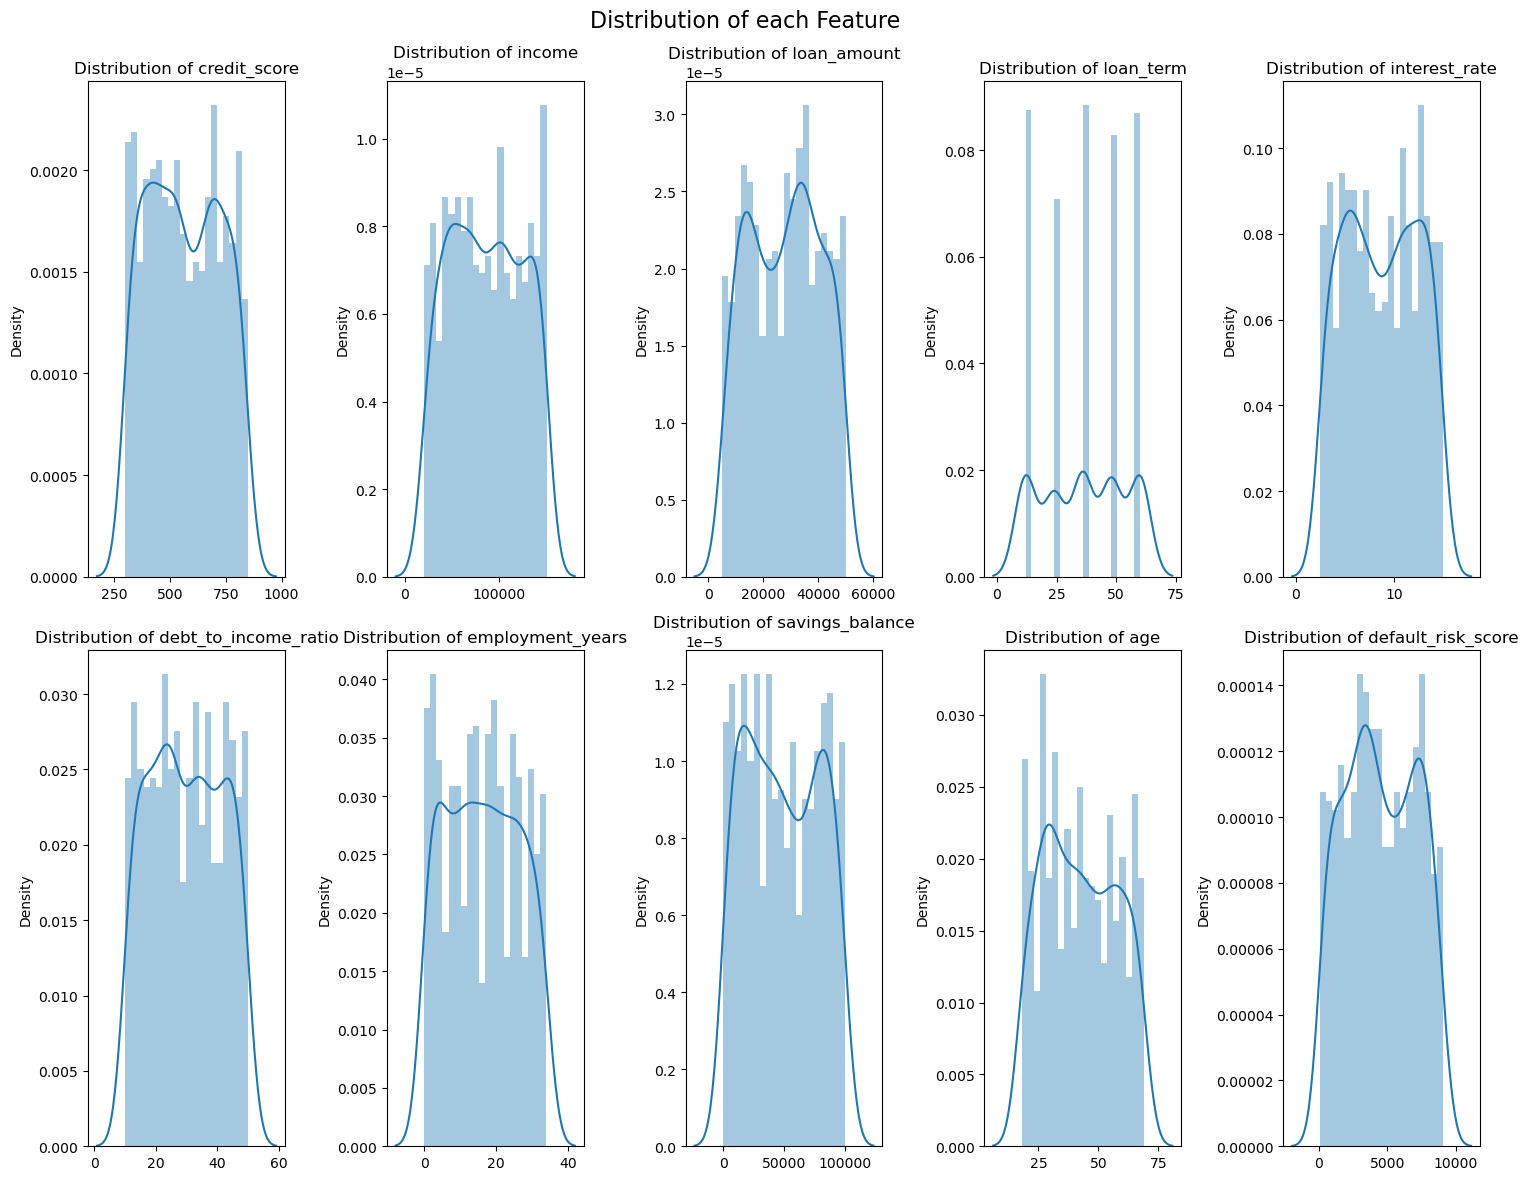

In [73]:
#set up the figure with subplots
fig, axes=plt.subplots(nrows=2, ncols=5, figsize=(15,12))
axes= axes.flatten()
#plot each features distribution
for i, column in enumerate(df.columns):
    sns.distplot(df[column], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {column}")
    axes[i].set_xlabel("")
plt.suptitle("Distribution of each Feature", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [74]:
#Split the data
target= "default_risk_score"
X= df.drop(columns=[target])
y= df[target]

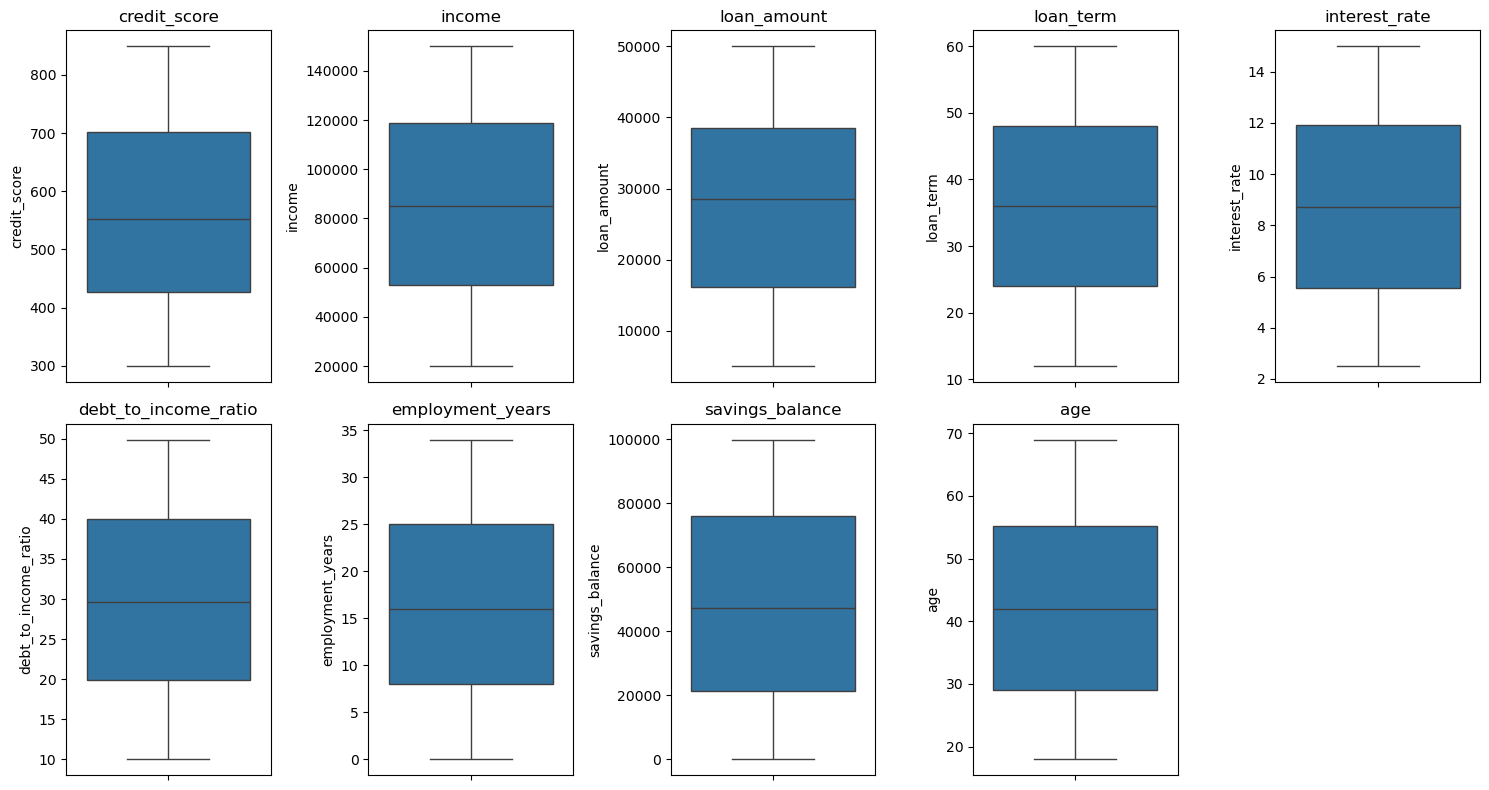

In [77]:
#Create a box plot for the features
plt.figure(figsize=(15, 8))
for i, feature in enumerate(X):
    plt.subplot(2, 5, i+1)
    sns.boxplot(y=df[feature])
    plt.title(feature)
    # plt.xlabel("Default Risk Score")
    plt.ylabel(X.columns[i])
plt.tight_layout();

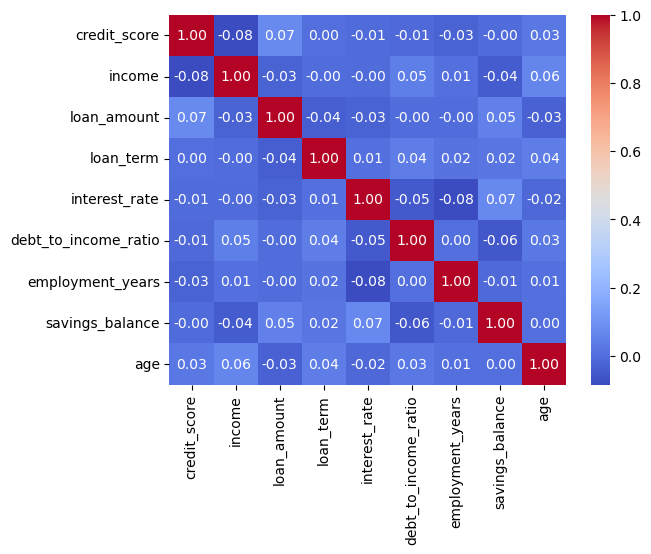

In [79]:
#Plot a heatmap to check for multicolinearity
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt='.2f');

In [81]:
#Fit the ols model
X = sm.add_constant(X)

model= sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     default_risk_score   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.272e+06
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        07:08:43   Log-Likelihood:                -3013.8
No. Observations:                 800   AIC:                             6048.
Df Residuals:                     790   BIC:                             6095.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.026e+04 

In [83]:
# Add constant column to X.
X_const = sm.add_constant(X)

df_vif= pd.DataFrame()
df_vif["feature"]= X_const.columns
df_vif["VIF"]= [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(df_vif)

                feature        VIF
0                 const  53.786900
1          credit_score   1.014323
2                income   1.015175
3           loan_amount   1.011773
4             loan_term   1.005604
5         interest_rate   1.015253
6  debt_to_income_ratio   1.009519
7      employment_years   1.007945
8       savings_balance   1.012595
9                   age   1.008272


In [85]:
X.columns

Index(['const', 'credit_score', 'income', 'loan_amount', 'loan_term',
       'interest_rate', 'debt_to_income_ratio', 'employment_years',
       'savings_balance', 'age'],
      dtype='object')

In [87]:
X= X.drop(columns=["const"])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   credit_score          800 non-null    int64  
 1   income                800 non-null    int64  
 2   loan_amount           800 non-null    int64  
 3   loan_term             800 non-null    int64  
 4   interest_rate         800 non-null    float64
 5   debt_to_income_ratio  800 non-null    float64
 6   employment_years      800 non-null    int64  
 7   savings_balance       800 non-null    int64  
 8   age                   800 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.4 KB


In [89]:
X.columns

Index(['credit_score', 'income', 'loan_amount', 'loan_term', 'interest_rate',
       'debt_to_income_ratio', 'employment_years', 'savings_balance', 'age'],
      dtype='object')

In [91]:
#Split into training and testing sets
X_train, X_test, y_train, y_test= train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

In [93]:
#perform Log transformation on the target variable
y= np.log1p(y)

In [95]:
#Scaling the features
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [97]:
#Reduce dimensionality 
pca= PCA(n_components=0.95)
X_train_pca= pca.fit_transform(X_train)
X_test_pca= pca.transform(X_test)
print("No. PCA components:", pca.n_components_)

<IPython.core.display.Javascript object>

No. PCA components: 9


In [99]:
#Ridge regression with GridSearchCV
ridge= Ridge()
params= {"alpha": [0.1, 1, 10, 100]}
grid_search= GridSearchCV(ridge, params, scoring="neg_mean_squared_error", cv=5)
grid_search.fit(X_train_pca, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print("Best cross-validation MSE: ", round(-grid_search.best_score_, 4))

#fit the model with best alpha
ridge_best= Ridge(alpha= grid_search.best_params_["alpha"])
ridge_best.fit(X_train_pca, y_train)

Best Parameters: {'alpha': 0.1}
Best cross-validation MSE:  116.2988


Ridge(alpha=0.1)

In [101]:
#predict
y_pred= ridge_best.predict(X_test_pca)

# Baseline prediction: Mean of training labels
y_pred_train = ridge_best.predict(X_train)
y_pred_test = ridge_best.predict(X_test)
baseline_mse = mean_squared_error(y_train, y_pred_train)
mse = mean_squared_error(y_test, y_pred)
mape= mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
    
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"R2 Score: {r2:.2f}")

MSE: 100.22
RMSE: 10.01
MAPE: 0.00
R2 Score: 1.00
